In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
import optuna


# Импорт библиотек

In [50]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C


## Выставление настроек

In [51]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Обработка данных

Начнем с того, что приведем все названия колонок к "змеиной нотации"

In [52]:
df.columns = df.columns.str.lower()
test.columns = test.columns.str.lower()

Переведем колонку с индексом в индекс датафрейма

In [53]:
df = df.set_index('passengerid')
test = test.set_index('passengerid')

Выведем общую информацию об обучающем и тестовом датасетах

In [54]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [55]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
survived,891,0,int64,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891,0,int64,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
name,891,0,object,,,,,,,,
sex,891,0,object,,,,,,,,
age,714,177,float64,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891,0,int64,891.0,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891,0,int64,891.0,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
ticket,891,0,object,,,,,,,,
fare,891,0,float64,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
cabin,204,687,object,,,,,,,,


In [56]:
full_info(test)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
pclass,418,0,int64,418.0,2.26555,0.841838,1.0,1.0,3.0,3.0,3.0
name,418,0,object,,,,,,,,
sex,418,0,object,,,,,,,,
age,332,86,float64,332.0,30.27259,14.181209,0.17,21.0,27.0,39.0,76.0
sibsp,418,0,int64,418.0,0.447368,0.89676,0.0,0.0,0.0,1.0,8.0
parch,418,0,int64,418.0,0.392344,0.981429,0.0,0.0,0.0,0.0,9.0
ticket,418,0,object,,,,,,,,
fare,417,1,float64,417.0,35.627188,55.907576,0.0,7.8958,14.4542,31.5,512.3292
cabin,91,327,object,,,,,,,,
embarked,418,0,object,,,,,,,,


Выводы следующие:
* В обучающем датасете 891 наблюдение
* Пропуски есть в колонках с возрастом и номером кабины(?). Пропуски есть также и в тестовом датасете, поэтому модель должна уметь работать с ними
* Не все типы данных оптимальны
* есть небольшой дисбаланс в пользу погибших

Удалим признак с номером кабины, так как восстановить эту информацию и использовать далее не удастся

In [57]:
try:
    df = df.drop('cabin', axis=1)
    test = test.drop('cabin', axis=1)
except:
    print('Признака уже нет')

Поменяем типы данных

In [58]:
df['pclass'] = df['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})
test['pclass'] = test['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})

In [59]:
df['sex'] = df['sex'].replace({'male': 0, 'female': 1}).astype('bool')
test['sex'] = test['sex'].replace({'male': 0, 'female': 1}).astype('bool')

Добавим новый признак, равный длине имени. Позже проверим, как это влияет на шансы выжить

In [60]:
df['name_length'] = df['name'].apply(len)
test['name_length'] = test['name'].apply(len)

Посмотрим на признак "номер билета"

In [61]:
df['ticket'].value_counts()

ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Совпадающих значений мало, удалим признак

In [62]:
df = df.drop('ticket', axis=1)
test = test.drop('ticket', axis=1)

# Исследование данных

Построим по порядку для всех признаков графики, позволяющие пока визуально оценить влияние признака на целевую переменную

## Номер класса

In [63]:
df.groupby('pclass')['survived'].value_counts(normalize=True).round(2)

pclass  survived
first   1           0.63
        0           0.37
second  0           0.53
        1           0.47
third   0           0.76
        1           0.24
Name: proportion, dtype: float64

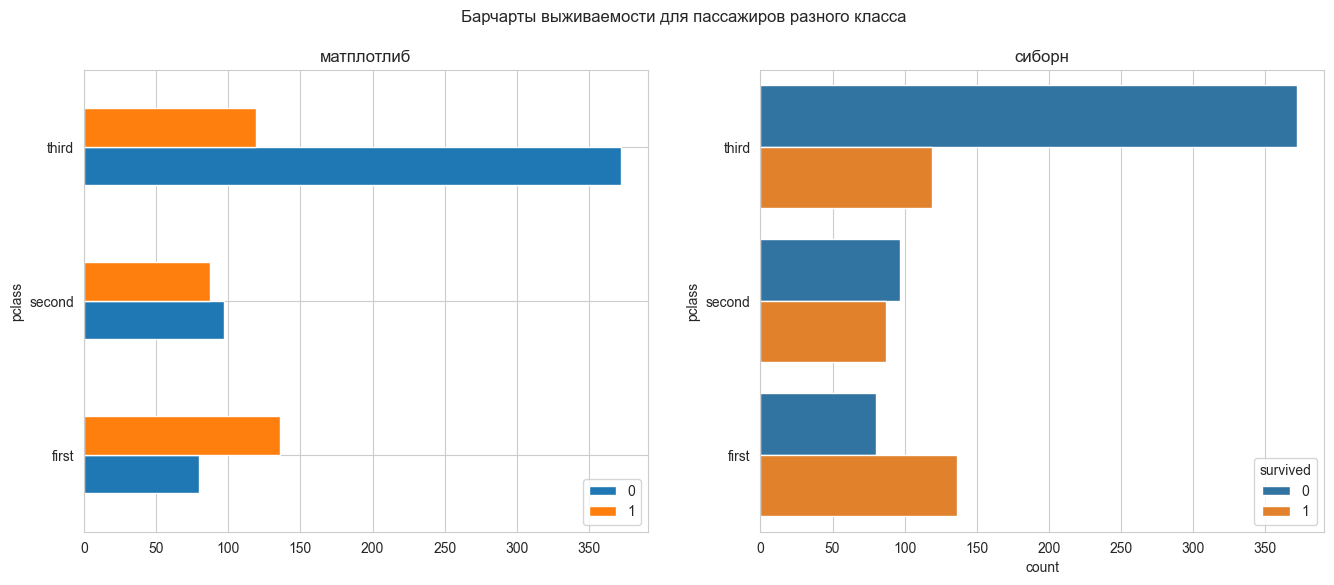

In [64]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle('Барчарты выживаемости для пассажиров разного класса')
df.groupby(['pclass', 'survived'])['survived'].value_counts().unstack().plot.barh(ax=ax1);
ax1.legend(loc='lower right');
ax1.set_title('матплотлиб')

sns.barplot(data=df.groupby(['pclass', 'survived'])['survived'].value_counts().reset_index(),
            y='pclass',
            order=['third', 'second', 'first'],
            x='count',
            hue='survived',
            # hue_order=[0, 1],
            orient='h',
            ax=ax2);
ax2.set_title('сиборн');

Предсказуемо, шансы выжить у пассажиров первого класса были выше

## Имя

Проверим, существует ли связь между длиной имени и вероятностью выжить.

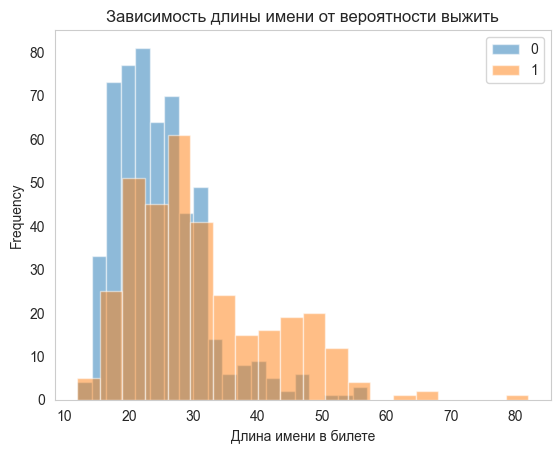

In [65]:
df.groupby('survived')['name_length'].plot(bins=20, alpha=0.5, kind='hist', grid=False);
plt.legend();
plt.title('Зависимость длины имени от вероятности выжить')
plt.xlabel('Длина имени в билете');

Удалим признак с именем

In [66]:
try:
    df = df.drop('name', axis=1)
except:
    pass

try:
    test = test.drop('name', axis=1)
except:
    pass

## Пол

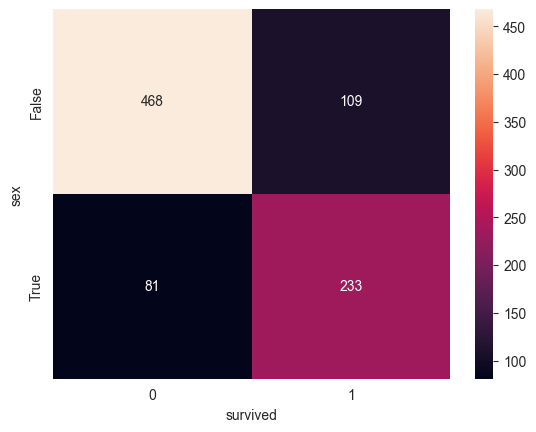

In [67]:
sns.heatmap(df.groupby(['sex', 'survived'])['survived'].count().unstack(), annot=True, fmt='.3g');

Среди женщин выжило примерно 75%, среди мужчин - 20%

## Возраст

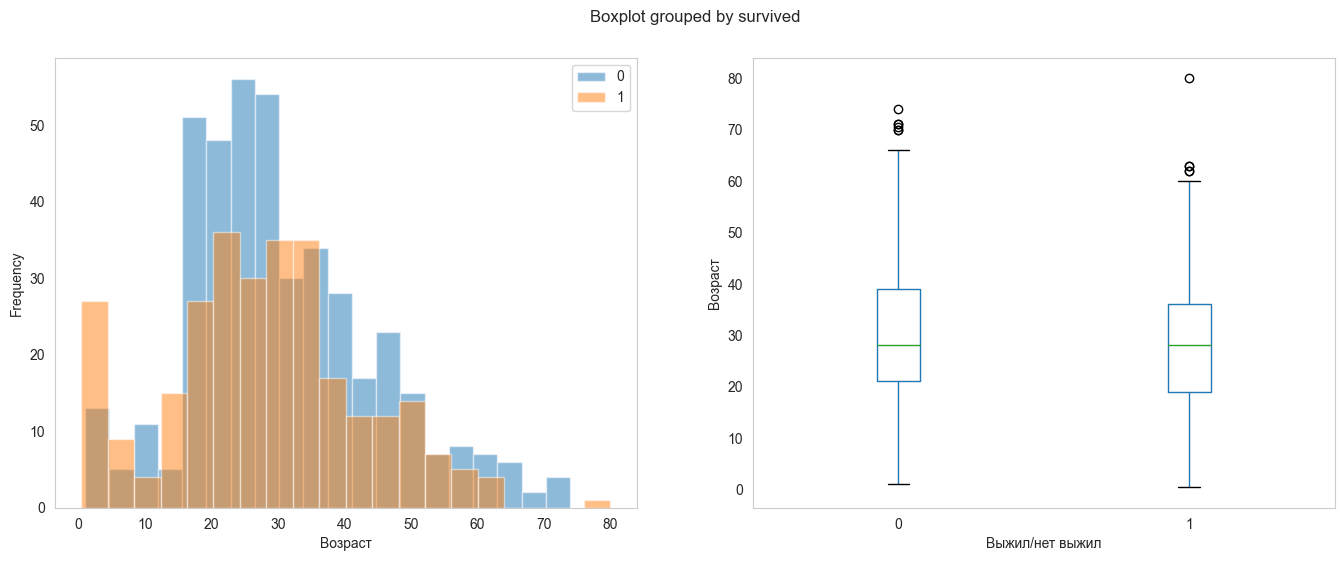

In [68]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

# fig.title('a')
fig.suptitle('b')
plt.title('c')
plt.suptitle('d')

df.groupby('survived')['age'].plot(bins=20, alpha=0.5, kind='hist', grid=False, ax=ax1);
ax1.legend();
ax1.set_xlabel('Возраст');

df.boxplot(column='age', by='survived', grid=False, ax=ax2);
ax2.set_xlabel('');
ax2.set_title('')
ax2.set_xlabel('Выжил/нет выжил')
ax2.set_ylabel('Возраст');

# Обучение моделей

## Разделение датасета на признаки и таргет, на обучающую и тестовую выборки

In [615]:
x = df.drop('survived', axis=1)
y = df['survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=761923)

## Создание таблицы с результатами

In [512]:
final_score = pd.DataFrame(columns=('model', 'searcher', 'params', 'cv_accuracy', 'train_accuracy', 'test_accuracy'))

Напишем функцию, заполняющую таблицу с результатами

In [513]:
def final_scorer(model_name='unknown',
                 searcher='unknown',
                 best_params={},
                 cv_best_score=np.nan,
                 train_accuracy=np.nan,
                 test_accuracy=np.nan):
    index = final_score.shape[0] + 1

    final_score.loc[index, 'model'] = model_name
    final_score.loc[index, 'searcher'] = searcher
    final_score.loc[index, 'params'] = list(best_params.items())
    final_score.loc[index, 'cv_accuracy'] = round(cv_best_score, 4)
    final_score.loc[index, 'train_accuracy'] = round(train_accuracy, 4)
    final_score.loc[index, 'test_accuracy'] = round(test_accuracy, 4)

    return final_score

## Линейные модели

In [514]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                remainder='passthrough')
Pipeline(steps=[('', transformer)])

Pipeline(steps=[('',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001287B030F10>),
                                                 ('cats',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001287B030B80>)]))])

Посмотрим на получившиеся признаки. У них теперь нет имен, но по порядку преобразвоаний можно увидеть, что последние 4 признака - это категориальные признаки, подвергнутые OHE.

In [515]:
full_info(pd.DataFrame(transformer.fit_transform(x_train)).astype('float'))

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
0,712,0,float64,712.0,2.494883e-18,1.000703,-0.742427,-0.742427,-0.742427,1.346933,1.346933
1,712,0,float64,712.0,-6.237208e-17,1.000703,-2.233092,-0.562814,0.000000,0.443377,3.926347
2,712,0,float64,712.0,1.871162e-18,1.000703,-0.481020,-0.481020,-0.481020,0.379498,6.403129
3,712,0,float64,712.0,-1.995907e-17,1.000703,-0.480998,-0.480998,-0.480998,-0.480998,6.580255
4,712,0,float64,712.0,3.617581e-17,1.000703,-0.718152,-0.539616,-0.376334,-0.005792,10.823706
5,712,0,float64,712.0,1.921060e-16,1.000703,-1.610042,-0.745850,-0.205731,0.334389,5.951632
6,712,0,float64,712.0,2.050562e-01,0.404026,0.000000,0.000000,0.000000,0.000000,1.000000
7,712,0,float64,712.0,5.533708e-01,0.497493,0.000000,0.000000,1.000000,1.000000,1.000000
8,712,0,float64,712.0,8.567416e-02,0.280079,0.000000,0.000000,0.000000,0.000000,1.000000
9,712,0,float64,712.0,7.317416e-01,0.443364,0.000000,0.000000,1.000000,1.000000,1.000000


Добавим в пайплайн классификатор

In [516]:
lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression(random_state=123))])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.01, 0.1, 1, 10]
          },
          { 'transformer__nums__imputer': [IterativeImputer(random_state=123)],
           'clf__penalty': [None, 'l2'],
           'clf__C': [0.001, 0.1, 1, 10]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='accuracy',
                        refit=True,
                        cv=5,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_;

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [ ]:
display(pd.DataFrame(lr_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {lr_gs.best_params_}',
      f'\naccuracy: {lr_gs.best_score_:.4f}')

In [ ]:
final_scorer(model_name='Logistic Regression',
             searcher='GridSearchCV',
             best_params=lr_gs.best_params_,
             cv_best_score=lr_gs.best_score_,
             train_accuracy=accuracy_score(y_train, lr_gs.best_estimator_.predict(x_train)),
             test_accuracy=accuracy_score(y_test, lr_gs.best_estimator_.predict(x_test)))

In [ ]:
lr = lr_gs.best_estimator_

Классификатор обучен и может уже что-то предсказывать. Посмотрим на важность признаков с точки зрения коэффициентов логистической регрессии и permutation_importance

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

pd.Series(lr.named_steps['clf'].coef_.reshape(-1), index=lr.named_steps['transformer'].get_feature_names_out()).sort_values().plot.barh(ax=ax1);
ax1.set_title('LR coefs');

r = permutation_importance(lr, x_train, y_train, scoring='roc_auc', n_repeats=30, random_state=123)
pd.Series(r.importances_mean, index=x_train.columns).sort_values().plot.barh(xerr=r.importances_std, ax=ax2);
ax2.set_title('Permutation importances');

### Метод опорных векторов

#### SVC

In [ ]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

# Параметр probability нужен, чтобы вернулись predict_proba. Это нужно для построения roc-auc и soft-voting
svm_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', SVC(random_state=123, probability=True))])

params = {'transformer__nums__scaler': [StandardScaler(), MinMaxScaler()],
          'estimator__C': range(1, 20),
          'estimator__gamma': [i/10000 for i in range(10)]}

gs_svc = GridSearchCV(svm_pipe, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, refit=True)

gs_svc.fit(x_train, y_train)
# {'estimator__C': 9, 'estimator__gamma': 0.009
svm_best = gs_svc.best_estimator_


In [ ]:
display(pd.DataFrame(gs_svc.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {gs_svc.best_params_}',
      f'\naccuracy: {gs_svc.best_score_:.4f}')

In [ ]:
final_scorer(model_name='SVC',
             searcher='GridSearchCV',
             best_params=gs_svc.best_params_,
             cv_best_score=gs_svc.best_score_,
             train_accuracy=accuracy_score(y_train, gs_svc.best_estimator_.predict(x_train)),
             test_accuracy=accuracy_score(y_test, gs_svc.best_estimator_.predict(x_test)))

#### LinearSVC

In [ ]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

svm_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', LinearSVC(max_iter=100000, random_state=123))])

params = {'transformer__nums__scaler': [StandardScaler(), MinMaxScaler()],
          'estimator__C': [2*i/100 for i in range(1, 100)]}

gs_lsvm = GridSearchCV(svm_pipe, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, refit=True, error_score='raise')
gs_lsvm.fit(x_train, y_train);
lsvm_best = gs_lsvm.best_estimator_

In [187]:
display(pd.DataFrame(gs_lsvm.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {gs_lsvm.best_params_}',
      f'\naccuracy: {gs_lsvm.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__nums__scaler,param_estimator__C,std_score_time,mean_score_time,std_fit_time,mean_fit_time
119,1,0.013892,0.800601,0.823944,0.802817,0.802817,0.790210,0.783217,"{'estimator__C': 1.2, 'transformer__nums__scal...",MinMaxScaler(),1.2,0.000633,0.011000,0.003137,0.059599
143,1,0.013892,0.800601,0.823944,0.802817,0.802817,0.790210,0.783217,"{'estimator__C': 1.44, 'transformer__nums__sca...",MinMaxScaler(),1.44,0.002059,0.012601,0.007222,0.062800
145,1,0.013892,0.800601,0.823944,0.802817,0.802817,0.790210,0.783217,"{'estimator__C': 1.46, 'transformer__nums__sca...",MinMaxScaler(),1.46,0.002785,0.011799,0.003407,0.062001
137,1,0.013892,0.800601,0.823944,0.802817,0.802817,0.790210,0.783217,"{'estimator__C': 1.38, 'transformer__nums__sca...",MinMaxScaler(),1.38,0.005914,0.014201,0.016726,0.069199
135,1,0.013892,0.800601,0.823944,0.802817,0.802817,0.790210,0.783217,"{'estimator__C': 1.36, 'transformer__nums__sca...",MinMaxScaler(),1.36,0.001020,0.011601,0.012759,0.075998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,190,0.013872,0.793578,0.816901,0.795775,0.795775,0.776224,0.783217,"{'estimator__C': 0.34, 'transformer__nums__sca...",StandardScaler(),0.34,0.008237,0.015601,0.243984,0.217810
7,195,0.013336,0.792160,0.809859,0.788732,0.795775,0.769231,0.797203,"{'estimator__C': 0.08, 'transformer__nums__sca...",MinMaxScaler(),0.08,0.005552,0.015000,0.036144,0.099200
5,196,0.015805,0.790761,0.809859,0.788732,0.795775,0.762238,0.797203,"{'estimator__C': 0.06, 'transformer__nums__sca...",MinMaxScaler(),0.06,0.000748,0.012203,0.006858,0.067400
3,197,0.015916,0.787944,0.809859,0.788732,0.781690,0.762238,0.797203,"{'estimator__C': 0.04, 'transformer__nums__sca...",MinMaxScaler(),0.04,0.004118,0.016200,0.001356,0.054401


параметры: {'estimator__C': 1.2, 'transformer__nums__scaler': MinMaxScaler()} 
accuracy: 0.8006


In [188]:
final_scorer(model_name='LinearSVC',
             searcher='GridSearchCV',
             best_params=gs_lsvm.best_params_,
             cv_best_score=gs_lsvm.best_score_,
             train_accuracy=accuracy_score(y_train, gs_lsvm.best_estimator_.predict(x_train)),
             test_accuracy=accuracy_score(y_test, gs_lsvm.best_estimator_.predict(x_test)))

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156


## Наивный Байес

In [189]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123)),
                         ('scaler', MinMaxScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

bayes_pipe = Pipeline(steps=[('transformer', transformer), ('estimator', BernoulliNB())])

params = [{'estimator': [BernoulliNB(), CategoricalNB(), ComplementNB()],
           'estimator__alpha': [0.1, 1, 10]},

          {'estimator': [GaussianNB()]}
         ]

gs_bayes = GridSearchCV(bayes_pipe, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)

gs_bayes.fit(x_train, y_train);

CPU times: total: 234 ms
Wall time: 842 ms


In [190]:
display(pd.DataFrame(gs_bayes.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {gs_bayes.best_params_}',
      f'\naccuracy: {gs_bayes.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_estimator__alpha,param_estimator,std_score_time,mean_score_time,std_fit_time,mean_fit_time
5,1,0.017073,0.790712,0.809859,0.781690,0.767606,0.783217,0.811189,"{'estimator': CategoricalNB(alpha=10), 'estima...",10,CategoricalNB(alpha=10),0.000802,0.012401,0.143116,0.131799
9,2,0.016733,0.790692,0.802817,0.774648,0.767606,0.811189,0.797203,{'estimator': GaussianNB()},NaN,GaussianNB(),0.008271,0.016999,0.019673,0.096401
3,3,0.014154,0.779513,0.802817,0.781690,0.767606,0.762238,0.783217,"{'estimator': CategoricalNB(alpha=10), 'estima...",0.1,CategoricalNB(alpha=10),0.005019,0.015002,0.162582,0.154000
4,3,0.014154,0.779513,0.802817,0.781690,0.767606,0.762238,0.783217,"{'estimator': CategoricalNB(alpha=10), 'estima...",1,CategoricalNB(alpha=10),0.001356,0.012400,0.149475,0.146398
0,5,0.016204,0.779504,0.795775,0.767606,0.781690,0.755245,0.797203,"{'estimator': BernoulliNB(), 'estimator__alpha...",0.1,BernoulliNB(),0.006968,0.015201,0.007338,0.059401
1,5,0.017947,0.779504,0.802817,0.767606,0.774648,0.755245,0.797203,"{'estimator': BernoulliNB(), 'estimator__alpha...",1,BernoulliNB(),0.002417,0.013398,0.011512,0.072801
2,7,0.016745,0.778105,0.802817,0.767606,0.774648,0.755245,0.790210,"{'estimator': BernoulliNB(), 'estimator__alpha...",10,BernoulliNB(),0.000749,0.012801,0.005900,0.063999
8,8,0.029266,0.757067,0.788732,0.781690,0.732394,0.713287,0.769231,"{'estimator': ComplementNB(), 'estimator__alph...",10,ComplementNB(),0.001264,0.012000,0.028806,0.078800
7,9,0.034176,0.754250,0.802817,0.774648,0.711268,0.720280,0.762238,"{'estimator': ComplementNB(), 'estimator__alph...",1,ComplementNB(),0.000800,0.011400,0.030336,0.072599
6,10,0.036126,0.750025,0.795775,0.774648,0.697183,0.720280,0.762238,"{'estimator': ComplementNB(), 'estimator__alph...",0.1,ComplementNB(),0.000490,0.011599,0.003577,0.057000


параметры: {'estimator': CategoricalNB(alpha=10), 'estimator__alpha': 10} 
accuracy: 0.7907


In [191]:
final_scorer(model_name='Naive Bayes',
             searcher='GridSearchCV',
             best_params=gs_bayes.best_params_,
             cv_best_score=gs_bayes.best_score_,
             train_accuracy=accuracy_score(y_train, gs_bayes.best_estimator_.predict(x_train)),
             test_accuracy=0)

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156
4,Naive Bayes,GridSearchCV,"[(estimator, CategoricalNB(alpha=10)), (estima...",0.7907,0.7893,0


## Деревянные модели

### Дерево решений

In [192]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                                   ('cats', cat_ct, selector(dtype_include="object"))],
                                                    remainder='passthrough')

tree_pipe = Pipeline(steps=[('transformer', transformer), ('clf', DecisionTreeClassifier(random_state=123))])

tree_params = {'transformer__cats__encoder': [OneHotEncoder(drop='first'), LabelEncoder()],
               'clf__max_depth': [2, 3, 4, 5, 7, 9],
               'clf__min_samples_split': [2, 3, 4, 5, 6, 8, 9, 10, 11],
               'clf__min_samples_leaf': [3, 5, 8, 9, 10, 11, 12, 14, 16]}

tree_gs = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='accuracy', cv=5, n_jobs=-1)
tree_gs.fit(x_train, y_train);
tree_best = tree_gs.best_estimator_

CPU times: total: 17.1 s
Wall time: 46.3 s


C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2430 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2430 fits failed with the following error:
Traceback (most recent call last):
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\pipeline.p

In [193]:
display(pd.DataFrame(tree_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {tree_gs.best_params_}',
      f'\naccuracy: {tree_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__cats__encoder,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
324,1,0.024844,0.807554,0.830986,0.809859,0.760563,0.811189,0.825175,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),2,3,4,0.005455,0.014200,0.009368,0.064201
328,1,0.024844,0.807554,0.830986,0.809859,0.760563,0.811189,0.825175,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),4,3,4,0.041485,0.037800,0.045267,0.094601
330,1,0.024844,0.807554,0.830986,0.809859,0.760563,0.811189,0.825175,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),5,3,4,0.002098,0.012999,0.061883,0.112401
332,1,0.024844,0.807554,0.830986,0.809859,0.760563,0.811189,0.825175,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),6,3,4,0.000491,0.012600,0.020838,0.072399
334,1,0.024844,0.807554,0.830986,0.809859,0.760563,0.811189,0.825175,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",OneHotEncoder(drop='first'),8,3,4,0.006242,0.014800,0.009064,0.062800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),3,12,4,0.000000,0.000000,0.002927,0.056197
437,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),4,12,4,0.000000,0.000000,0.011258,0.064403
439,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),5,12,4,0.000000,0.000000,0.004584,0.059597
403,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'clf__max_depth': 4, 'clf__min_samples_leaf':...",LabelEncoder(),5,10,4,0.000000,0.000000,0.006118,0.058401


параметры: {'clf__max_depth': 4, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'transformer__cats__encoder': OneHotEncoder(drop='first')} 
accuracy: 0.8076


In [194]:
final_scorer(model_name='DecisionTreeClassifier',
             searcher='GridSearchCV',
             best_params=tree_gs.best_params_,
             cv_best_score=tree_gs.best_score_,
             train_accuracy=accuracy_score(y_train, tree_gs.best_estimator_.predict(x_train)),
             test_accuracy=accuracy_score(y_test, tree_gs.best_estimator_.predict(x_test)))

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156
4,Naive Bayes,GridSearchCV,"[(estimator, CategoricalNB(alpha=10)), (estima...",0.7907,0.7893,0
5,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 4), (clf__min_samples_leaf, ...",0.8076,0.8455,0.8268


### Случайный лес

In [219]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

rf_pipe = Pipeline(steps=[('transformer', transformer), ('clf', RandomForestClassifier(random_state=123))])

rf_params = {'clf__n_estimators': [ 28, 29, 30, 31, 32, 33],
             'clf__max_depth': [ 7, 8, 9, 10],
             'clf__min_samples_split': [2, 3, 4, 5],
             'clf__min_samples_leaf': [1, 2, 3, 4, 5]}

rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, scoring='accuracy', cv=5, n_jobs=-1, refit=True)
rf_gs.fit(x_train, y_train);
rf_best = rf_gs.best_estimator_

CPU times: total: 47.4 s
Wall time: 3min 21s


In [220]:
rf_gs.best_params_

{'clf__max_depth': 9,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 30}

In [221]:
display(pd.DataFrame(rf_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {rf_gs.best_params_}',
      f'\naccuracy: {rf_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
1481,1,0.014590,0.835664,0.852113,0.838028,0.809859,0.832168,0.846154,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",30,4,3,9,0.000748,0.018200,0.018859,0.164838
1470,1,0.014590,0.835664,0.852113,0.838028,0.809859,0.832168,0.846154,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",30,3,3,9,0.000748,0.018799,0.007229,0.159400
1459,1,0.014590,0.835664,0.852113,0.838028,0.809859,0.832168,0.846154,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",30,2,3,9,0.000489,0.018400,0.006337,0.163200
1503,1,0.014590,0.835664,0.852113,0.838028,0.809859,0.832168,0.846154,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",30,6,3,9,0.000001,0.018001,0.013275,0.164399
1492,1,0.014590,0.835664,0.852113,0.838028,0.809859,0.832168,0.846154,"{'clf__max_depth': 9, 'clf__min_samples_leaf':...",30,5,3,9,0.000632,0.018001,0.005345,0.160799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,2633,0.019305,0.796356,0.830986,0.781690,0.781690,0.783217,0.804196,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",30,7,5,5,0.002828,0.020000,0.007043,0.145316
271,2633,0.019305,0.796356,0.830986,0.781690,0.781690,0.783217,0.804196,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",30,2,5,5,0.004224,0.019600,0.006066,0.141000
304,2633,0.019305,0.796356,0.830986,0.781690,0.781690,0.783217,0.804196,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",30,5,5,5,0.000980,0.018200,0.009912,0.151400
718,2639,0.022164,0.796307,0.802817,0.802817,0.753521,0.804196,0.818182,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",26,7,1,7,0.011427,0.023200,0.004924,0.147400


параметры: {'clf__max_depth': 9, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 30} 
accuracy: 0.8357


In [222]:
final_scorer(model_name='RandomForestClassifier',
             searcher='GridSearchCV',
             best_params=rf_gs.best_params_,
             cv_best_score=rf_gs.best_score_,
             train_accuracy=accuracy_score(y_train, rf_gs.best_estimator_.predict(x_train)),
             test_accuracy=accuracy_score(y_test, rf_gs.best_estimator_.predict(x_test)))

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156
4,Naive Bayes,GridSearchCV,"[(estimator, CategoricalNB(alpha=10)), (estima...",0.7907,0.7893,0
5,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 4), (clf__min_samples_leaf, ...",0.8076,0.8455,0.8268
6,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 9), (clf__min_samples_leaf, ...",0.8357,0.8933,0.8156
7,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547
8,StackingClassifier,,[],0.8076,0.861,0.8324
9,VotingClassifier,,[],0.8371,0.8753,0.8001
10,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547


### ExtraTreesClassifier

In [199]:
%%time
num_ct = Pipeline(steps=[('imputer', IterativeImputer(random_state=123))])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                                remainder='passthrough')

et_pipe = Pipeline(steps=[('transformer', transformer), ('clf', ExtraTreesClassifier(random_state=123))])

et_params = {'clf__n_estimators': [20, 23, 24, 25, 26, 27, 30],
             'clf__max_depth': [5, 6, 7, 8, 9],
             'clf__min_samples_split': [2, 3, 4, 5, 6],
             'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}

et_gs = GridSearchCV(et_pipe, param_grid=et_params, scoring='accuracy', cv=5, n_jobs=-1, refit=True)
et_gs.fit(x_train, y_train);
et_best = et_gs.best_estimator_

CPU times: total: 22.8 s
Wall time: 1min 16s


In [200]:
display(pd.DataFrame(et_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {et_gs.best_params_}',
      f'\naccuracy: {et_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
759,1,0.024352,0.817414,0.852113,0.788732,0.809859,0.797203,0.839161,"{'clf__max_depth': 8, 'clf__min_samples_leaf':...",25,5,2,8,0.002332,0.020599,0.008997,0.130200
517,2,0.018120,0.814607,0.845070,0.795775,0.802817,0.804196,0.825175,"{'clf__max_depth': 7, 'clf__min_samples_leaf':...",30,5,2,7,0.004166,0.020799,0.005572,0.133600
258,3,0.011573,0.814597,0.830986,0.802817,0.802817,0.811189,0.825175,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",30,3,2,6,0.001356,0.019400,0.008328,0.133800
249,3,0.011573,0.814597,0.830986,0.802817,0.802817,0.811189,0.825175,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",26,2,2,6,0.002333,0.019399,0.008809,0.131001
251,3,0.011573,0.814597,0.830986,0.802817,0.802817,0.811189,0.825175,"{'clf__max_depth': 6, 'clf__min_samples_leaf':...",30,2,2,6,0.001165,0.018801,0.007885,0.136200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1221,0.014749,0.786497,0.802817,0.767606,0.774648,0.804196,0.783217,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",25,4,6,5,0.000401,0.017201,0.028841,0.131400
143,1221,0.014749,0.786497,0.802817,0.767606,0.774648,0.804196,0.783217,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",25,2,6,5,0.000489,0.016601,0.004079,0.109598
164,1221,0.014749,0.786497,0.802817,0.767606,0.774648,0.804196,0.783217,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",25,5,6,5,0.001020,0.018400,0.001496,0.117599
150,1221,0.014749,0.786497,0.802817,0.767606,0.774648,0.804196,0.783217,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",25,3,6,5,0.001600,0.018800,0.014170,0.123001


параметры: {'clf__max_depth': 8, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 25} 
accuracy: 0.8174


In [208]:
final_scorer(model_name='ExtraTreesClassifier',
             searcher='GridSearchCV',
             best_params=et_gs.best_params_,
             cv_best_score=et_gs.best_score_,
             train_accuracy=accuracy_score(y_train, et_gs.best_estimator_.predict(x_train)),
             test_accuracy=accuracy_score(y_test, et_gs.best_estimator_.predict(x_test)))

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156
4,Naive Bayes,GridSearchCV,"[(estimator, CategoricalNB(alpha=10)), (estima...",0.7907,0.7893,0
5,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 4), (clf__min_samples_leaf, ...",0.8076,0.8455,0.8268
6,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 9), (clf__min_samples_leaf, ...",0.8357,0.8933,0.8156
7,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547
8,StackingClassifier,,[],0.8076,0.861,0.8324
9,VotingClassifier,,[],0.8371,0.8753,0.8001
10,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547


## Ансамбли

### BaggingClassifier

BaggingClassifier почему-то не воспринимает трансформации по типам колонок внутри пайплайна, поэтому перепишем трансформер и пересоберем пайплайн, указав трансформируемые признаки индексами

In [209]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression(random_state=123))])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          },
          { 'transformer__nums__imputer': [IterativeImputer(random_state=123)],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='accuracy',
                        refit=True,
                        cv=5,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x_train, y_train)
lr_best = lr_gs.best_estimator_;

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [210]:
bc = BaggingClassifier(estimator=lr_best, n_estimators=10, random_state=123)
cross_val_score(bc, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1).mean().round(4)

0.795

ну хз

### StackingClassifier

In [211]:
sc = StackingClassifier(estimators=[('rf', rf_best), ('et', et_best)],
                        final_estimator=RandomForestClassifier(n_estimators=15, max_depth=7),
                        cv=3,
                        n_jobs=-1)
sc_cv = cross_val_score(sc, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1).mean().round(4)
sc_cv

0.8104

In [212]:
final_scorer(model_name='StackingClassifier',
             searcher='',
             best_params={},
             cv_best_score=sc_cv,
             train_accuracy=accuracy_score(y_train, sc.fit(x_train, y_train).predict(x_train)),
             test_accuracy=accuracy_score(y_test, sc.fit(x_train, y_train).predict(x_test)))

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156
4,Naive Bayes,GridSearchCV,"[(estimator, CategoricalNB(alpha=10)), (estima...",0.7907,0.7893,0
5,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 4), (clf__min_samples_leaf, ...",0.8076,0.8455,0.8268
6,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 9), (clf__min_samples_leaf, ...",0.8357,0.8933,0.8156
7,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547
8,StackingClassifier,,[],0.8076,0.861,0.8324
9,VotingClassifier,,[],0.8371,0.8753,0.8001
10,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547


### VotingClassifier

In [213]:
vc = VotingClassifier(estimators=[('lr', lr_best),
                                  ('tree', tree_best),
                                  ('rf', rf_best),
                                  ('et', et_best)],
                      voting='soft',
                      weights = (0.802, 0.8076, 0.8357, 0.8174),
                      n_jobs=-1)
vc_cv = cross_val_score(vc, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1).mean().round(4)

In [214]:
final_scorer(model_name='VotingClassifier',
             searcher='',
             best_params={},
             cv_best_score=vc_cv,
             train_accuracy=roc_auc_score(y_train, vc.fit(x_train, y_train).predict(x_train)),
             test_accuracy=roc_auc_score(y_test, vc.fit(x_train, y_train).predict(x_test)))

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
2,SVC,GridSearchCV,"[(estimator__C, 6), (estimator__gamma, 0.0008)...",0.7963,0.7837,0.7989
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156
4,Naive Bayes,GridSearchCV,"[(estimator, CategoricalNB(alpha=10)), (estima...",0.7907,0.7893,0
5,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 4), (clf__min_samples_leaf, ...",0.8076,0.8455,0.8268
6,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 9), (clf__min_samples_leaf, ...",0.8357,0.8933,0.8156
7,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547
8,StackingClassifier,,[],0.8076,0.861,0.8324
9,VotingClassifier,,[],0.8371,0.8753,0.8001
10,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547


In [218]:
final_score.sort_values('cv_accuracy', ascending=False)

,model,searcher,params,cv_accuracy,train_accuracy,test_accuracy
9,VotingClassifier,,[],0.8371,0.8753,0.8001
12,VotingClassifier,,[],0.8371,0.8753,0.8001
6,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 9), (clf__min_samples_leaf, ...",0.8357,0.8933,0.8156
7,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547
10,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 8), (clf__min_samples_leaf, ...",0.8174,0.8666,0.8547
11,StackingClassifier,,[],0.8104,0.868,0.8156
5,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 4), (clf__min_samples_leaf, ...",0.8076,0.8455,0.8268
8,StackingClassifier,,[],0.8076,0.861,0.8324
1,Logistic Regression,GridSearchCV,"[(clf__C, 10), (clf__penalty, l2), (transforme...",0.802,0.8034,0.8268
3,LinearSVC,GridSearchCV,"[(estimator__C, 1.2), (transformer__nums__scal...",0.8006,0.802,0.8156


## Фиксация промежуточных результатов

Пусть лучший результат показали VotingClassifier и RandomForestClassifier. Подберем для них оптимальные пороги для наилучшего accuracy. Мы убедились, что модели не переобучены, поэтому обучим их на полном датасете и на нем же подберем лучший порог и предскажем скор

In [643]:
print(f'для логистической регрессии среднее CV: {cross_val_score(lr_best, x, y, cv=5, scoring="accuracy").mean():.4f},'
      f'\nстандартное отклонение {cross_val_score(lr_best, x, y, cv=5, scoring="accuracy").std():.4f}')

для логистической регрессии среднее CV: 0.8020,
стандартное отклонение 0.0056


In [617]:
print(f'для леса среднее CV: {cross_val_score(rf_best, x, y, cv=5, scoring="accuracy").mean():.4f},'
      f'\nстандартное отклонение {cross_val_score(rf_best, x, y, cv=5, scoring="accuracy").std():.4f}')

для леса среднее CV: 0.8137,
стандартное отклонение 0.0143


In [618]:
cross_val_score(submission_model, x, y, cv=6, scoring='accuracy')

array([0.77852349, 0.80536913, 0.83892617, 0.7972973 , 0.79054054,
       0.7972973 ])

In [619]:
def thr_checker(model, features, target):
    model.fit(features, target)
    thresholds = model.predict_proba(x)[:, 1]
    score = []
    for thr in thresholds:
        y_pred = thresholds>thr
        score.append(accuracy_score(y, y_pred))

    return thresholds, score

In [632]:
submission_model = lr_best

In [633]:
thresholds_train, score_train = thr_checker(submission_model, x_train, y_train)

In [634]:
submission_model.fit(x_train, y_train)
thresholds_test = submission_model.predict_proba(x_test)[:, 1]
score_test = [accuracy_score(y_test, submission_model.predict_proba(x_test)[:, 1]>thr) for thr in thresholds_test]

In [635]:
thresholds_train[np.argmax(score_train)]

0.6348366272547155

In [636]:
thresholds_test[np.argmax(score_test)]

0.5259210276186668

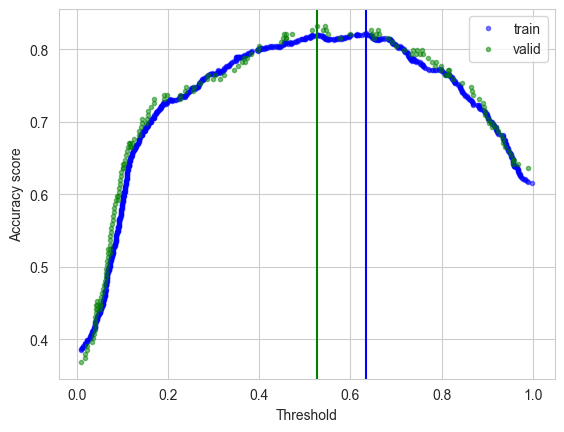

In [646]:
plt.plot(thresholds_train, score_train, '.b', alpha=0.5, label='train')
plt.axvline(thresholds_train[np.argmax(score_train)], c='b');

plt.plot(thresholds_test, score_test, '.g', alpha=0.5, label='valid')
plt.axvline(thresholds_test[np.argmax(score_test)], c='g');

plt.legend();
plt.xlabel('Threshold')
plt.ylabel('Accuracy score');

In [647]:
x_test

,pclass,sex,age,sibsp,parch,fare,embarked,name_length
passengerid,,,,,,,,
758,second,False,18.0,0,0,11.5000,S,24
141,third,True,NaN,0,2,15.2458,C,29
153,third,False,55.5,0,0,8.0500,S,16
346,second,True,24.0,0,0,13.0000,S,29
281,third,False,65.0,0,0,7.7500,Q,16
...,...,...,...,...,...,...,...,...
615,third,False,35.0,0,0,8.0500,S,31
566,third,False,24.0,2,0,24.1500,S,20
561,third,False,NaN,0,0,7.7500,Q,24


In [608]:
submission_model.fit(x, y)
submission = pd.DataFrame({'Survived': submission_model.predict_proba(test)[:, 1]>0.55}, index=test.index).astype('int')
submission.index.name = 'PassengerId'
submission

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [609]:
submission.to_csv('submission.csv')

## Градиентный бустинг

### XGBoost

XGBoost не умеет работать с категориальными признаками напрямую, поэтому преобразуем данные заранее

In [75]:
%%time
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

xgb_pipe = Pipeline(steps=[('transformer', transformer), ('clf', xgb.XGBClassifier())])

params = {'clf__n_estimators': [15, 25, 50],
          'clf__max_depth': [3, 4, 5, 6, 7],
          'clf__learning_rate': [00.1, 0.1, 0.4]}

xgb_gs   = GridSearchCV(estimator=xgb_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
xgb_gs.fit(x_train, y_train)
xgb_best = xgb_gs.best_estimator_;

Fitting 3 folds for each of 45 candidates, totalling 135 fits
CPU times: total: 1 s
Wall time: 4.59 s


In [76]:
display(pd.DataFrame(xgb_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1])
print(f'параметры: {xgb_gs.best_params_}',
      f'\nroc-auc: {xgb_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_clf__n_estimators,param_clf__max_depth,param_clf__learning_rate,std_score_time,mean_score_time,std_fit_time,mean_fit_time
22,1,0.029469,0.863210,0.889393,0.822039,0.878198,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",25,5,0.1,4.670762e-04,0.013662,0.010330,0.194336
7,1,0.029469,0.863210,0.889393,0.822039,0.878198,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",25,5,0.1,3.865647e-02,0.040333,0.005888,0.234001
4,3,0.039649,0.860872,0.903148,0.807834,0.871635,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",25,4,0.1,9.439772e-04,0.015666,0.009844,0.491334
19,3,0.039649,0.860872,0.903148,0.807834,0.871635,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",25,4,0.1,8.174109e-04,0.014000,0.006236,0.149528
2,5,0.028965,0.860661,0.889543,0.821064,0.871376,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",50,3,0.1,4.706960e-04,0.014332,0.002450,1.046513
17,5,0.028965,0.860661,0.889543,0.821064,0.871376,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",50,3,0.1,1.885931e-03,0.015333,0.008653,0.236193
8,7,0.030166,0.860571,0.887631,0.818478,0.875603,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",50,5,0.1,2.625095e-03,0.016333,0.017933,0.557335
23,7,0.030166,0.860571,0.887631,0.818478,0.875603,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",50,5,0.1,4.661444e-04,0.014329,0.001694,0.317335
5,9,0.033491,0.860205,0.890517,0.813531,0.876567,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",50,4,0.1,9.433040e-04,0.014668,0.070901,0.490666
20,9,0.033491,0.860205,0.890517,0.813531,0.876567,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",50,4,0.1,4.790694e-04,0.013661,0.010838,0.297533


параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 25} 
roc-auc: 0.8632


In [78]:
final_scorer(model_name='XGBClassifier',
             searcher='GridSearchCV',
             best_params=xgb_gs.best_params_,
             cv_best_score=xgb_gs.best_score_,
             train_accuracy=roc_auc_score(y_train, xgb_gs.predict_proba(x_train)[:, 1]),
             test_accuracy=roc_auc_score(y_test, xgb_gs.predict_proba(x_test)[:, 1]))

,model,searcher,params,cv_roc_auc,train_roc_auc,test_roc_auc
1,lr,some,"[(d, 3)]",5.6,6.2454,NaN
2,Logistic Regression,GridSearchCV,"[(clf__C, 100), (clf__penalty, l2), (transform...",0.8552,0.8629,0.8648
3,SVC,GridSearchCV,"[(estimator__C, 16), (estimator__gamma, 0.0009...",0.8486,0.8545,0.8505
4,LinearSVC,GridSearchCV,"[(estimator__C, 1.9), (transformer__nums__scal...",0.8554,0.8616,0.8625
5,Naive Bayes,GridSearchCV,"[(estimator, ComplementNB(alpha=1)), (estimato...",0.8321,0.8348,0.858
6,DecisionTreeClassifier,GridSearchCV,"[(clf__max_depth, 5), (clf__min_samples_leaf, ...",0.8395,0.9042,0.8632
7,RandomForestClassifier,GridSearchCV,"[(clf__max_depth, 7), (clf__min_samples_leaf, ...",0.8667,0.9191,0.8819
8,ExtraTreesClassifier,GridSearchCV,"[(clf__max_depth, 6), (clf__min_samples_leaf, ...",0.8641,0.8996,0.8926
9,StackingClassifier,,NaN,NaN,NaN,NaN
10,StackingClassifier,,NaN,NaN,NaN,NaN


Попробуем добавить регуляризацию при помощи early_stopping. Встроить такую конструкцию в ГридСерч не получилось

In [79]:
%%time
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, (1, 2, 3, 4, 5, 7)),
                                              ('cats', cat_ct, [0, 6])],
                                remainder='passthrough')

x_train_tr = transformer.fit_transform(x_train)
x_test_tr = transformer.transform(x_test)

xgb_clf = xgb.XGBClassifier(n_estimators=500,
                            max_depth=3,
                            eval_metric="auc",
                            learning_rate=0.05,
                            early_stopping_rounds=50)

xgb_clf.fit(x_train_tr, y_train, eval_set=[(x_train_tr, y_train), (x_test_tr, y_test)]);

[0]	validation_0-auc:0.86484	validation_1-auc:0.90162
[1]	validation_0-auc:0.86484	validation_1-auc:0.90162
[2]	validation_0-auc:0.86484	validation_1-auc:0.90162
[3]	validation_0-auc:0.86484	validation_1-auc:0.90162
[4]	validation_0-auc:0.86701	validation_1-auc:0.90229
[5]	validation_0-auc:0.87450	validation_1-auc:0.89534
[6]	validation_0-auc:0.87585	validation_1-auc:0.89615
[7]	validation_0-auc:0.87585	validation_1-auc:0.89615
[8]	validation_0-auc:0.87603	validation_1-auc:0.89089
[9]	validation_0-auc:0.87775	validation_1-auc:0.89528
[10]	validation_0-auc:0.87642	validation_1-auc:0.88988
[11]	validation_0-auc:0.87630	validation_1-auc:0.88718
[12]	validation_0-auc:0.87634	validation_1-auc:0.88772
[13]	validation_0-auc:0.87834	validation_1-auc:0.88839
[14]	validation_0-auc:0.87910	validation_1-auc:0.88934
[15]	validation_0-auc:0.87965	validation_1-auc:0.88839
[16]	validation_0-auc:0.87990	validation_1-auc:0.88934
[17]	validation_0-auc:0.88101	validation_1-auc:0.88306
[18]	validation_0-au

Прикрутим Оптуну

In [ ]:
def objective(trial):
    # Define the search space for hyperparameters
    param = {
        'objective': 'binary:logitraw',
        'eval_metric': 'auc',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        # 'num_boost_round': 100000, # Fix the boosting round and use early stopping
        'max_depth': trial.suggest_int('max_depth', 3, 10)
        # 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        # 'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        # 'lambda': trial.suggest_float('lambda', 0.1, 10.0),
        # 'alpha': trial.suggest_float('alpha', 0.0, 10.0),
    }

    # Split the data into further training and validation sets (three sets are preferable)
    train_data, valid_data, train_target, valid_target = train_test_split(x_train_tr, y_train, test_size=0.2, random_state=42)

    # Convert the data into DMatrix format
    dtrain = xgb.DMatrix(train_data, label=train_target)
    dvalid = xgb.DMatrix(valid_data, label=valid_target)

    # Define the pruning callback for early stopping
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-rmse')

    # Train the model with early stopping
    model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], num_boost_round=1000000, early_stopping_rounds=50)

                      # , callbacks=[pruning_callback])

    # Make predictions on the test set
    dtest = xgb.DMatrix(valid_data)
    y_pred = model.predict(dtest)

    # Calculate the root mean squared error
    roc_auc = roc_auc_score(valid_target, y_pred)

    return roc_auc

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=100, timeout=10, n_jobs=-1) # Control the number of trials

# Print the best hyperparameters and the best score
best_params = study.best_params
best_roc_auc = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best roc_auc: ", best_roc_auc)

[I 2023-06-20 13:12:31,179] A new study created in memory with name: no-name-fcfab61a-8144-4574-961b-bf4b8617f21e


[0]	validation-auc:0.84916
[0]	validation-auc:0.84186
[0]	validation-auc:0.84186
[0]	validation-auc:0.83946[0]	validation-auc:0.83946
[0]	validation-auc:0.83946
[0]	validation-auc:0.84916

[0]	validation-auc:0.83986
[0]	validation-auc:0.83946
[0]	validation-auc:0.83946
[1]	validation-auc:0.86645
[0]	validation-auc:0.84056
[1]	validation-auc:0.83407
[1]	validation-auc:0.85966
[1]	validation-auc:0.84166[1]	validation-auc:0.87795
[1]	validation-auc:0.87485

[1]	validation-auc:0.83537
[2]	validation-auc:0.86086[0]	validation-auc:0.84916[1]	validation-auc:0.83537


[1]	validation-auc:0.85986
[2]	validation-auc:0.84986
[1]	validation-auc:0.84026
[1]	validation-auc:0.83507
[2]	validation-auc:0.84346
[2]	validation-auc:0.87275
[2]	validation-auc:0.86196
[2]	validation-auc:0.86325
[2]	validation-auc:0.83896
[2]	validation-auc:0.84206[3]	validation-auc:0.86445
[1]	validation-auc:0.86645

[2]	validation-auc:0.86515
[3]	validation-auc:0.87535[3]	validation-auc:0.85676

[2]	validation-auc:0.83896
[